In [1]:
import pandas as pd
import numpy as np
data_path = "/Users/edoardocamerinelli/Desktop/momentum_contrarian_unified/approaches/vectorized_contrarian_monthly/data/daily_equity_curve_6m_lookback.csv"

df = pd.read_csv(data_path)

In [2]:
# Filtro drawdown vettorizzato senza bias (con shift per evitare lookahead bias)
# Applica il filtro su 'cumulative_returns'

equity = df['cumulative_returns'].values

# Calcolo del massimo precedente (rolling max)
roll_max = pd.Series(equity).cummax().values
drawdown = (equity - roll_max) / roll_max

threshold = -0.05
state = np.ones_like(equity, dtype=int)
out = False
for i in range(1, len(equity)):
    if out:
        if drawdown[i] > threshold:
            out = False
            state[i] = 1
        else:
            state[i] = 0
    else:
        if drawdown[i] <= threshold:
            out = True
            state[i] = 0
        else:
            state[i] = 1

# Applica lo shift: la decisione di oggi vale per domani (no bias)
state = np.roll(state, 1)
state[0] = 1  # il primo giorno si parte sempre investiti

df['invested'] = state

display(df[['Date', 'cumulative_returns', 'invested']].head(20))

# Mostra i punti di uscita e rientro
exit_points = df.index[(df['invested'].shift(1) == 1) & (df['invested'] == 0)].tolist()
entry_points = df.index[(df['invested'].shift(1) == 0) & (df['invested'] == 1)].tolist()
print(f"Punti di uscita: {exit_points}")
print(f"Punti di rientro: {entry_points}")

,Date,cumulative_returns,invested
0,2000-08-23,1.000000,1
1,2000-08-24,1.000000,1
2,2000-08-25,1.000000,1
3,2000-08-28,1.000000,1
4,2000-08-29,1.000000,1
5,2000-08-30,1.000000,1
6,2000-08-31,1.000000,1
7,2000-09-01,0.993836,1
8,2000-09-05,0.966428,1
9,2000-09-06,0.975343,1


Punti di uscita: [31, 42, 212, 215, 221, 392, 406, 419, 433, 448, 465, 476, 489, 1582, 1629, 1679, 1743, 1750, 1801, 1807, 1922, 2004, 2021, 2024, 2055, 2057, 2067, 2095, 2151, 2165, 2211, 2213, 2215, 2231, 2312, 2319, 2326, 2329, 2440, 2443, 2511, 2527, 2534, 2537, 2576, 2579, 2598, 2603, 2613, 2633, 2648, 2655, 2720, 2766, 2774, 2793, 2798, 2819, 2834, 2836, 2850, 2855, 2949, 2959, 2980, 2982, 2999, 3032, 3039, 3107, 3121, 3517, 3524, 3529, 3573, 3576, 3581, 3586, 3599, 3624, 3629, 3647, 3767, 3787, 3798, 3802, 3814, 3818, 3898, 3900, 3924, 3935, 3967, 3970, 3975, 3988, 4018, 4115, 4141, 4186, 4198, 4287, 4300, 4314, 4328, 4339, 4387, 4396, 4509, 4512, 4532, 4539, 4614, 4620, 4704, 4708, 4712, 4714, 4740, 4760, 4783, 4785, 4837, 4863, 4867, 4969, 4978, 4980, 4988, 5057, 5074, 5083, 5094, 6062, 6066, 6070, 6116, 6126, 6129, 6136, 6139, 6144, 6147, 6179, 6195, 6214, 6219, 6221, 6233, 6236, 6244]
Punti di rientro: [34, 210, 214, 220, 391, 397, 407, 420, 446, 464, 475, 482, 1565, 1627, 1

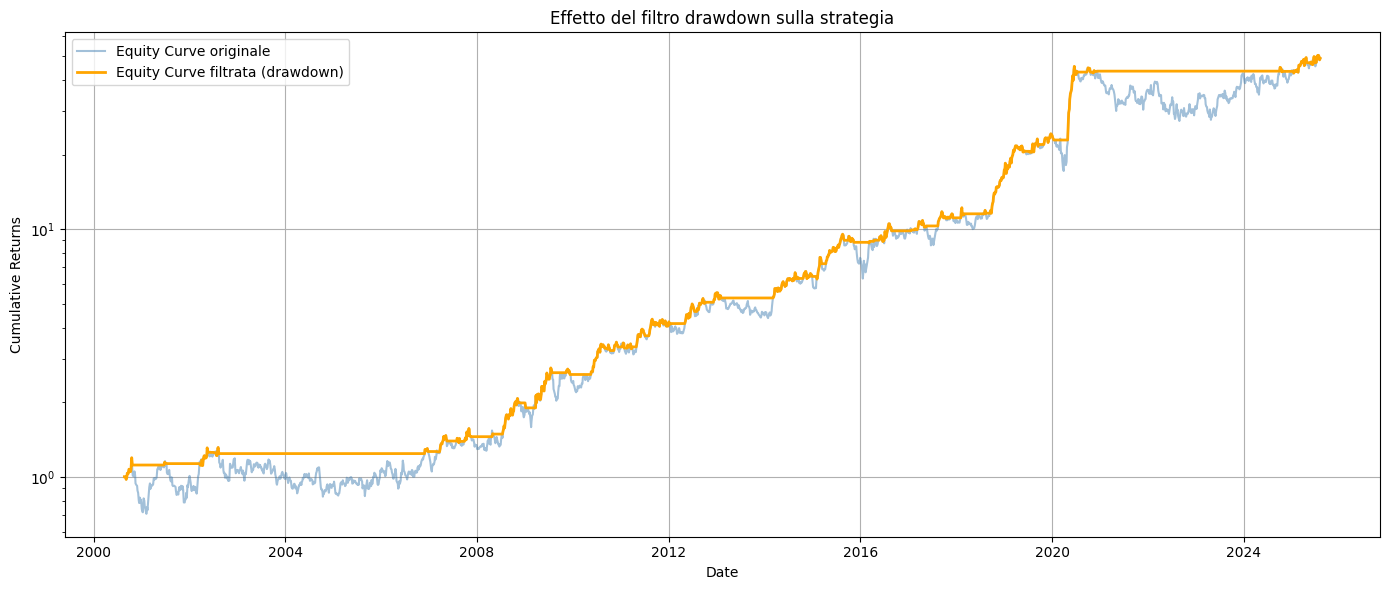

In [3]:
# Visualizzazione grafica della strategia con e senza filtro drawdown (corretto, log scale)
import matplotlib.pyplot as plt

# Assicura che la colonna Date sia datetime
if not np.issubdtype(df['Date'].dtype, np.datetime64):
    df['Date'] = pd.to_datetime(df['Date'])

# Calcola la curva filtrata: piatta nei periodi out
filtered_curve = df['cumulative_returns'].copy()
mask = df['invested'] == 0
filtered_curve[mask] = np.nan
filtered_curve = filtered_curve.ffill()

# Ottimizza il plot per DataFrame grandi
step = max(1, len(df) // 2000)

plt.figure(figsize=(14,6))
plt.plot(df['Date'][::step], df['cumulative_returns'][::step], label='Equity Curve originale', alpha=0.5, color='steelblue')
plt.plot(df['Date'][::step], filtered_curve[::step], label='Equity Curve filtrata (drawdown)', linewidth=2, color='orange')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Effetto del filtro drawdown sulla strategia')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()